# Examining fits of neurons in the brain-wide map

First let's do some data I/O, loading in our fits from a given date and looking at the distribution of D^2 scores by session:

In [1]:
from ipywidgets import interact
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import re
import brainbox.io.one as bbone

CLEANUP = True

%matplotlib inline
fitdate = '2022-01-09'
fitpath = Path('/home/berk/Documents/Projects/results/glms/')
fitfiles = [fitpath.joinpath(subjdir).joinpath(sessdir).joinpath(file)
            for subjdir in os.listdir(fitpath) 
            for sessdir in os.listdir(fitpath.joinpath(subjdir))
            for file in os.listdir(fitpath.joinpath(subjdir).joinpath(sessdir))
            if re.match(f'.*{fitdate}.*stepwise_regression\.pkl', file)]
filedata = {}
for filename in fitfiles:
    data = np.load(filename, allow_pickle=True)

    filedata[filename] = data


In [4]:
observed_regions = []
for key, ses in filedata.items():
    unitdf = pd.Series(ses['clu_regions'])
    observed_regions.extend(unitdf.unique())
allregions = list(set(observed_regions))
print(len(filedata), len(allregions))

152 418


In [6]:
%qtconsole

In [4]:
# animals = list(set([filedata[s]['sessinfo']['nickname'] for s in filedata]))

# nsess = len(filedata)
# fig, axes = plt.subplots(np.ceil(len(filedata) / 4).astype(int), 4, sharex=True, figsize=(10, nsess / 4 * 2.5))
# axes = axes.flatten()
# scorebins = np.linspace(-0.1, 1., 20)
# for i, s in enumerate(filedata):
#     scores = filedata[s]['scores']
#     sinfo = filedata[s]['sessinfo']
#     axes[i].hist(scores.iloc[:, -1], bins=scorebins)
#     axes[i].set_title(sinfo['nickname'] + ' ' + str(sinfo['sessdate']))

In [3]:
from ibllib.atlas import BrainRegions
from ibllib.atlas import AllenAtlas
from iblutil import ismember

sess_strs = {s['sessinfo']['nickname'] + ' from ' +
             s['sessinfo']['sessdate'] + ' probe: ' +
             fn[fn.find('probe') + 5] : fn for fn, s in filedata.items()}
orig_fns = list(filedata.keys())
n_cov = tmpdict['scores'].shape[1]
masterscores = []
for i, fn in enumerate(filedata):
    scores = filedata[fn]['scores'].copy()
    scores = scores.rename(columns={x: f'{x + 1}cov_score' for x in range(n_cov)}).astype(float)
    sequences = filedata[fn]['sequences'].copy()
    sequences = sequences.rename(columns={x: f'{x + 1}cov_name' for x in range(n_cov)}).astype(str)
    outscores = scores.join(sequences)
    regions = filedata[fn]['unit_regions']
    outscores['acronym'] = regions
    outscores['eid'] = filedata[fn]['sessinfo']['eid']
    try:
        outscores['probe'] = filedata[fn]['probe']
    except KeyError:
        pix = fn.find('probe')
        outscores['probe'] = fn[pix: pix + 7]
    outscores = outscores[pd.notna(outscores['acronym'])]
    masterscores.append(outscores)
masterscores = pd.concat(masterscores)

for i in range(1, n_cov + 1):  # Change this for diff num covs
    if i >= 2:
        diff = masterscores[str(i) + 'cov_score'] - masterscores[str(i - 1) + 'cov_score']
    else:
        diff = masterscores[str(i) + 'cov_score']
    masterscores[str(i) + 'cov_diff'] = diff


brainregions = BrainRegions()
def remap(ids, source='Allen', dest='Beryl', output='acronym'):
    br = brainregions
    _, inds = ismember(ids, br.id[br.mappings[source]])
    ids = br.id[br.mappings[dest][inds]]
    if output == 'id':
        return br.id[br.mappings[dest][inds]]
    elif output == 'acronym':
        return br.get(br.id[br.mappings[dest][inds]])['acronym']

def get_id(acronym):
    return brainregions.id[np.argwhere(brainregions.acronym == acronym)[0, 0]]

def get_name(acronym):
    if acronym == 'void':
        return acronym
    reg_idxs = np.argwhere(brainregions.acronym == acronym).flat
    return brainregions.name[reg_idxs[0]]

def label_cerebellum(acronym):
    regid = brainregions.id[np.argwhere(brainregions.acronym == acronym).flat][0]
    ancestors = brainregions.ancestors(regid)
    if 'Cerebellum' in ancestors.name or 'Medulla' in ancestors.name:
        return True
    else:
        return False

grpby = masterscores.groupby('acronym')
masterscores['reg_id'] = grpby.acronym.transform(lambda g: get_id(g.unique()[0]))
masterscores['beryl_acr'] = grpby.reg_id.transform(lambda g: remap(g))
masterscores['cerebellum'] = grpby.acronym.transform(lambda g: label_cerebellum(g.unique()[0]))
masterscores['region'] = masterscores['beryl_acr']
masterscores['name'] = grpby.region.transform(lambda g: get_name(g.unique()[0]))

rawpoints = masterscores.melt(id_vars=[*[f'{i}cov_name' for i in range(1, n_cov + 1)],
                                       'name', 'reg_id', 'acronym', 'region', 
                                       'cerebellum', 'eid', 'clu_id', 'fold'],
                              value_vars=[f'{i}cov_diff' for i in range(1, n_cov + 1)],
                              ignore_index=False)
rawpoints['covname'] = rawpoints.apply(lambda x: x[str(int(x.variable[0])) + 'cov_name'], axis=1)
rawpoints['position'] = rawpoints.apply(lambda x: int(x.variable[0]), axis=1)
rawpoints = rawpoints.drop(columns=[f'{i}cov_name' for i in range(1, n_cov + 1)])
rawpoints['percentile'] = rawpoints.groupby(['covname', 'region']).value.rank(pct=True)

<ipython-input-3-f6ea1d8b31d2>:3: DeprecationWarning: brainbox.numerical is deprecated; use iblutil.numerical
  from brainbox.numerical import ismember


## Looking at fit characteristics by region

Next we would like to investigate the characteristics of single-neuron fits, conditioned by region. First, we will look at the $D^2$ (also known as pseudo-$R^2$) scores by region. We want to know for a given region:

1. What proportion of cells have a given kernel as the argmax for single-kernel $D^2$ scores, and what the distribution of scores for that kernel are given that it is the argmax kernel

2. Conditioned on a given first kernel, what the addtional explainability ($\Delta D^2$) is for each of the subsequent kernel options

In [ ]:
## Random shit



Text(0.5, 1.0, 'Proportion of cells with argmax prior_tr')

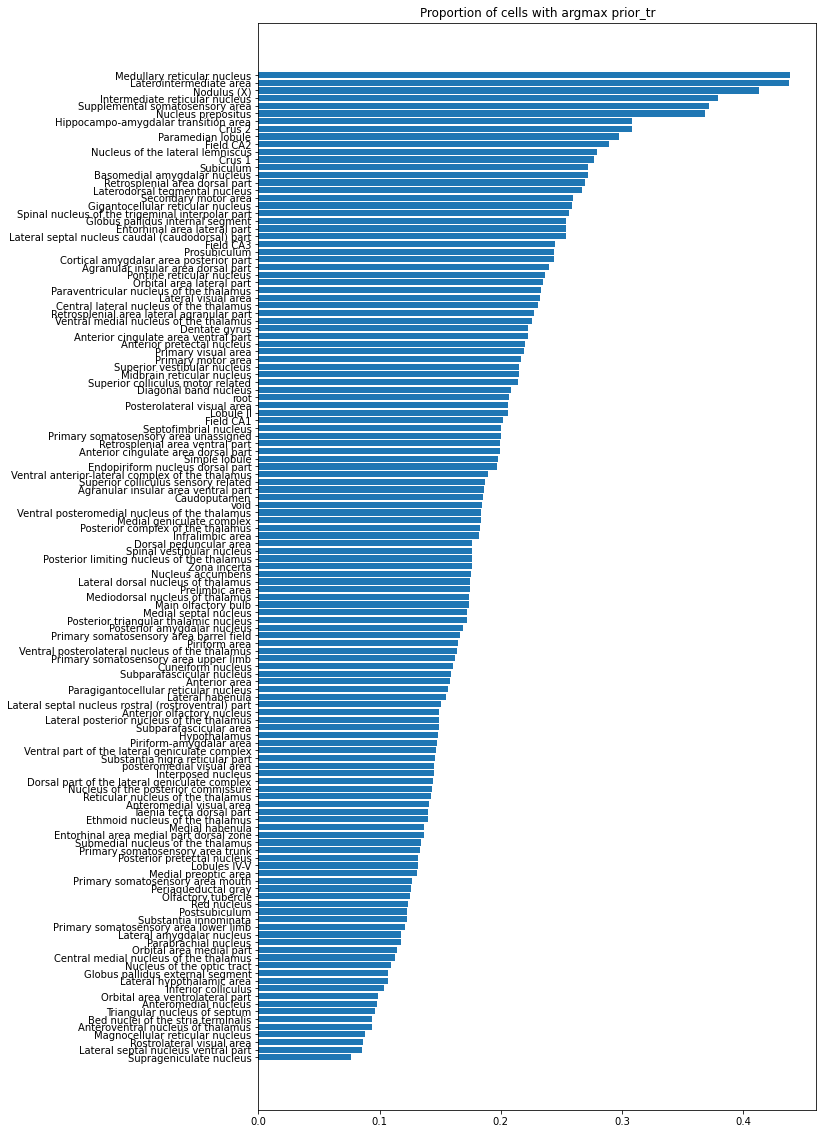

In [9]:
kern_name = 'prior_tr'
grouper = 'name'

topregions = masterscores[grouper].value_counts()
topregions = topregions[topregions > 50]

topreg_master = masterscores[np.isin(masterscores[grouper], topregions.index)].copy()
def drop_subzero_max(row):
    if row['1cov_diff'] < 0:
        row['1cov_name'] = 'None'
    return row

topreg_master = topreg_master.apply(drop_subzero_max, axis=1)
badinds = topreg_master.index[topreg_master['1cov_name'] == 'None']
topreg_melt = rawpoints[np.isin(rawpoints[grouper], topregions.index)].drop(index=badinds)

kern_props = topreg_master.groupby(grouper)['1cov_name'].apply(pd.value_counts, normalize=True)
target_props = kern_props.loc[:, kern_name].sort_values()

plt.figure(figsize=(10, 20))
plt.barh(range(len(target_props)), target_props, tick_label=target_props.index)
plt.gca().set_title(f'Proportion of cells with argmax {kern_name}')


Text(0.5, 0, '$\\Delta D^2$')

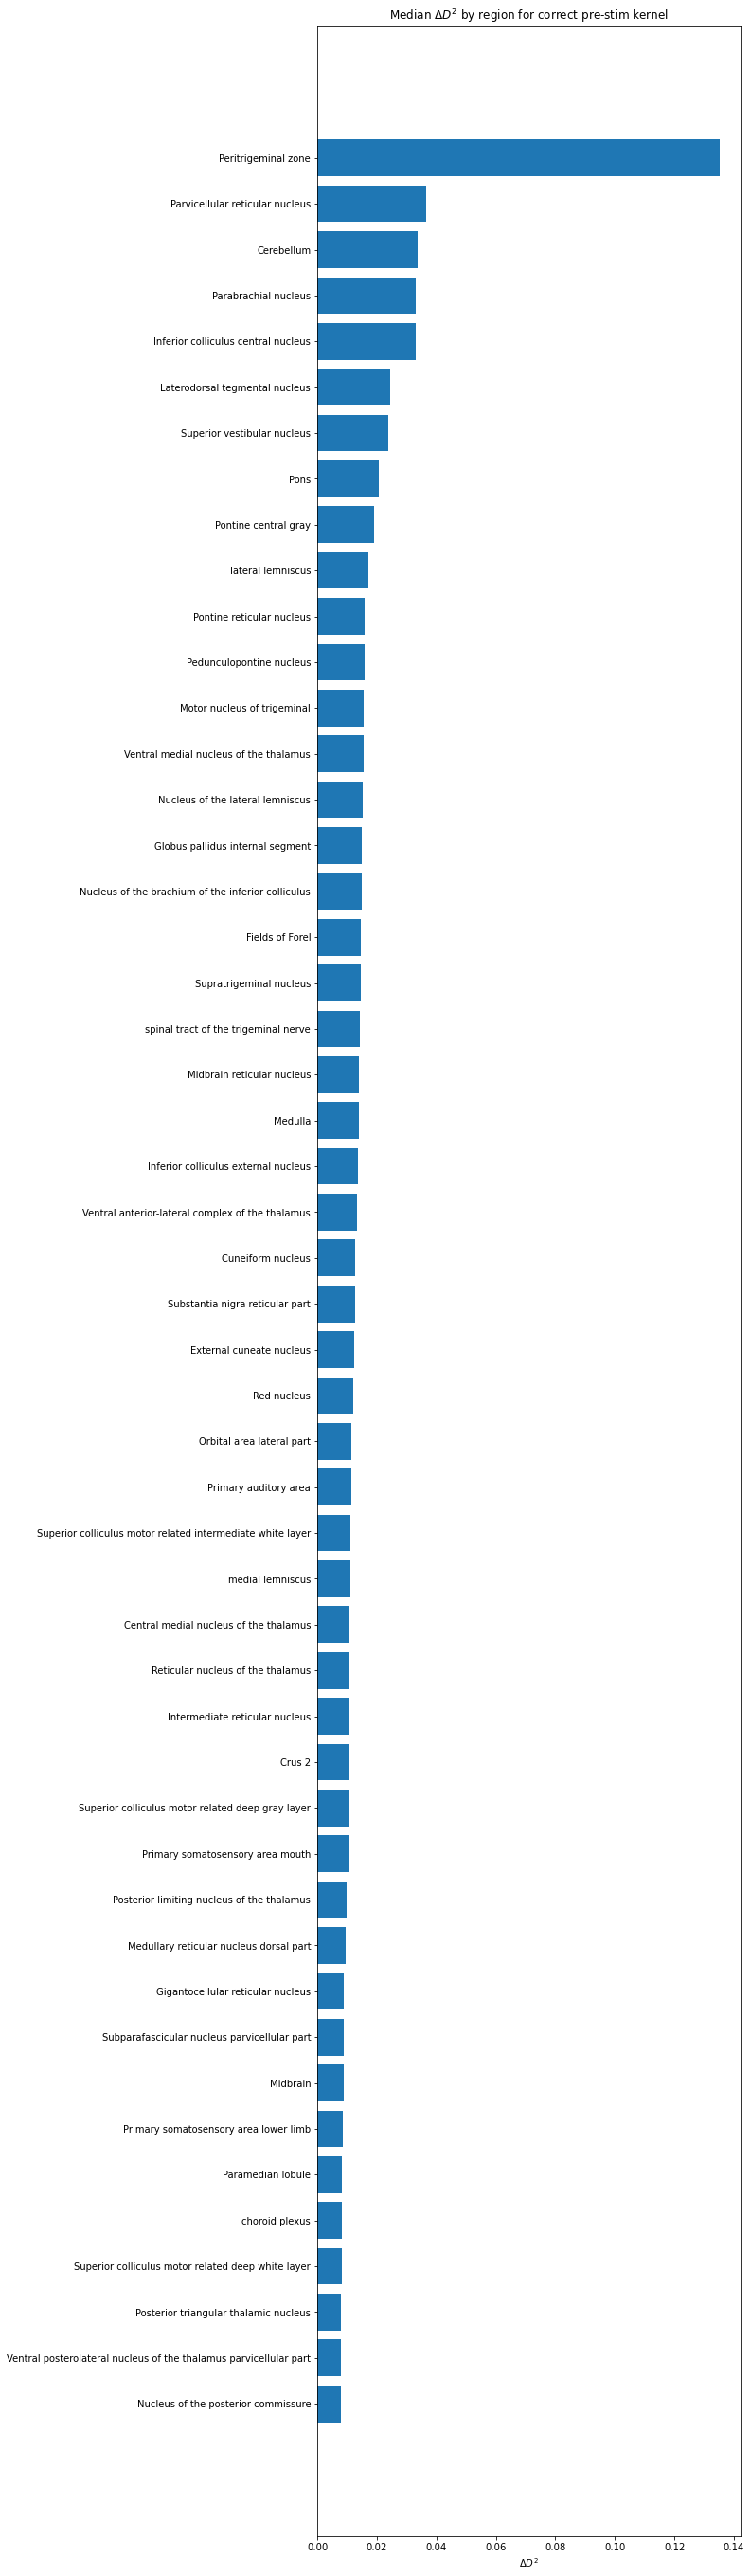

In [148]:
n_regions = 50

fig, ax = plt.subplots(1, 1, figsize=(8, len(topregions) * 0.25))
covmelt = topreg_melt[topreg_melt.covname == kern_name]
medians = covmelt.groupby(grouper).agg({'value':'median'}).sort_values('value', ascending=False)[:n_regions]
# short_medians = short_pleft_covmelt.groupby(g
#rouper).agg({'value':'median'}).sort_values('value', ascending=False)[:n_regions]
# shared_regions = [x for x in medians.index if x in short_medians.index]
ax.barh(range(len(medians)), medians.values.flatten()[::-1], tick_label=medians.index[::-1])
ax.set_title(r'Median $\Delta D^2$ by region for' + f' {kern_name} pre-stim kernel')
ax.set_xlabel(r'$\Delta D^2$')
# for label in ax.get_yticklabels():
#     if label.get_text() in shared_regions:
#         label.set_color('red')

In [17]:
# diffs = short_medians - medians
# topdiffs = diffs.sort_values(by='value', ascending=False)
# topdiffs

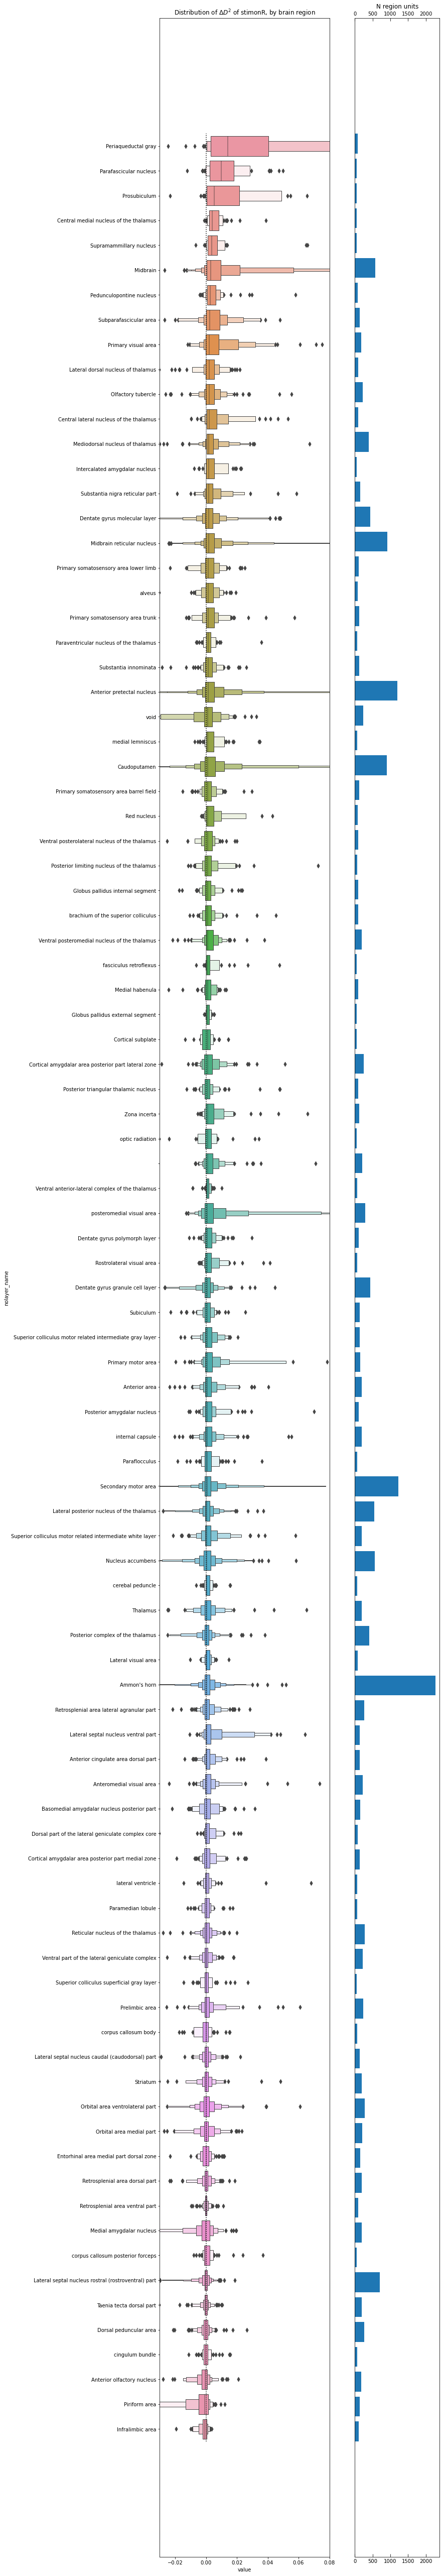

In [18]:
badinds = topreg_master.index[topreg_master.tag_0 == 'None']
topreg_melt = rawpoints[np.isin(rawpoints[grouper], topregions.index)].drop(index=badinds)
topreg_melt['group'] = topreg_melt['covname'].apply(lambda st: kern_name if st == kern_name else 'others')
regorder = topreg_melt[topreg_melt.covname == kern_name].groupby(grouper).agg({'value':'median'}).sort_values('value', ascending=False).index
fig, ax = plt.subplots(1, 2, figsize=(10, len(topregions)), gridspec_kw={'width_ratios': [2, 1]})
sns.boxenplot(data=topreg_melt[topreg_melt.group == kern_name], x='value', y=grouper,
#               hue='group', hue_order=[kern_name, 'others'],
              order=regorder, ax=ax[0])
if kern_name == 'correct':
    ax[0].set_xlim([-0.05, 0.50])
else:
    ax[0].set_xlim([-0.03, 0.08])
ax[0].vlines(0, ax[0].get_ylim()[0], ax[0].get_ylim()[1], color='k', ls=':')
ax[0].set_title(r'Distribution of $\Delta D^2$' + f' of {kern_name}, by brain region')
# ax[0].set_yticklabels(ax[0].get_yticklabels(), rotation=45)

ax[1].barh(ax[0].get_yticks(), topreg_master[grouper].value_counts().loc[regorder].iloc[::-1])
ax[1].set_yticks([])
ax[1].set_title('N region units')
ax[1].tick_params(labeltop=True, top=True, direction='in', length=6)